# Historical Volatility

## From prices to returns
It is commmon to model the stock prices as log-normally distributed, leading to normally distributed log-returns.

Log-normal implies positive only prices and the normal distribution is very familliar

We will assume the same for BTC/USD prices and verify the assumption at a later stage.

If S is the price of BTC in USD, then ΔS is the change in price for a very short time period Δt. 
The simple return then is r(Δt) = ΔS / S and the log-return: ln[ r(Δt) ] = ln( ΔS / S ].

In discreet form:
```
r(t) = [S(t) - S(t-1)] / S(t-1)
r(t) = S(t) / S(t-1) - 1
```
and

```
ln[ r(t) ] = ln[ S(t) / S(t-1) - 1 ]
ln[ r(t) ] = ln[ S(t) / S(t-1) ]  - ln [ 1 ]
ln[ r(t) ] = ln[ S(t) / S(t-1) ]  - 0
ln[ r(t) ] = ln[ S(t) / S(t-1) ]
```

Therefore starting with the 1-minute (bar/candle) BTC price series, the 1-minute log return is the natural log of the ratio between the current price and the previous.

The analysis is for a 2-minute time period so even if the data is on 1-minute period, the code will lookback 2 periods to account for it.



In [11]:

import math

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt

from math import log, sqrt, exp, pi
from scipy.stats import norm

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'


## Load the prices and look at some data points

In [7]:

btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min.head(5)

,open,high,low,close
date,,,,
2012-01-02 20:04,5.0,5.0,5.0,5.0
2012-01-03 11:45,5.3,5.3,5.3,5.3
2012-01-03 14:22,5.1,5.1,5.1,5.1
2012-01-03 14:54,5.3,5.3,5.3,5.3
2012-01-03 15:32,5.3,5.3,5.3,5.3


In [9]:
btcusd_1min.tail(5)

,open,high,low,close
date,,,,
2022-05-31 10:32,31599.1,31599.1,31599.1,31599.1
2022-05-31 10:33,31599.1,31599.1,31599.1,31599.1
2022-05-31 10:34,31607.3,31618.1,31607.3,31614.7
2022-05-31 10:35,31611.0,31615.3,31596.4,31601.7
2022-05-31 10:36,31601.7,31610.1,31600.1,31605.2


## Calculate the 2-minute log-return from the 'close' and plot both

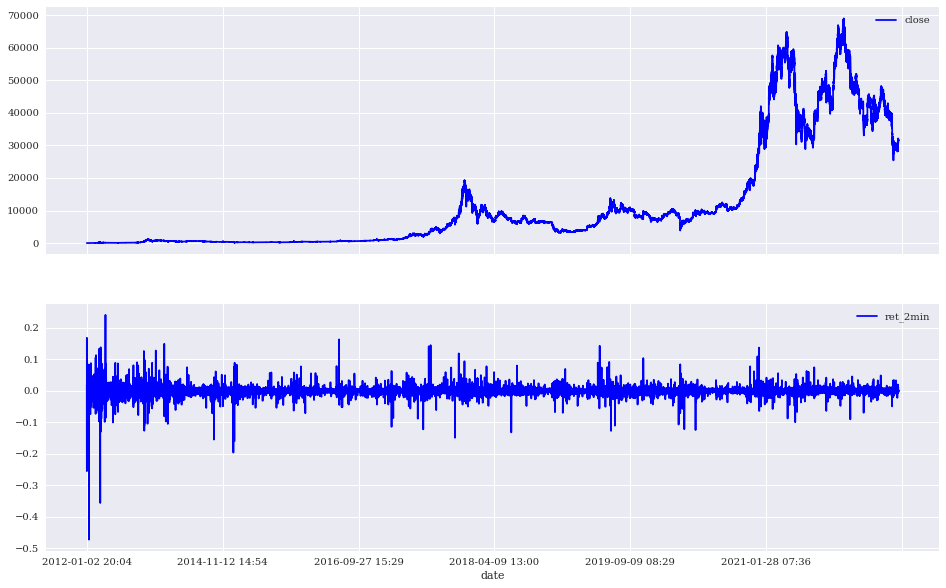

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

In [16]:

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

btcusd_1min[['close', 'ret_2min']].plot(subplots=True, style='b', figsize=(16, 10))

plt.show()

## From returns to volatility

The _assumed_ normal property of the returns is used to infer information about the distribution of an observed sample, i.e. the historical data.

The distribution of the returns over a period of T years follows a Normal distribution defined by it's two parameters, the mean and the variance:

```
ln[r] ~ Normal( mean, variance )
where 
mean = μ-σ^2/2
variance = standard deviation^2 = σ^2/T
```

So the standard deviation (the measure of uncertainty about the mean) is given by σ/√T which is used as volatility (the measure of uncertainty about the returns).

Using the sample standard deviation estimate from the emperical log-returns and accounting for Δt = 2-minute, the 2-minute volatility and annualized volatility can be calculated.

```
t = number of 2-minute time period per year
annualized volatility = sample standard deviation estimate / √t
```


## Calculate the 2-minute volatility

In [25]:

vol_2min = btcusd_1min['ret_2min'].std()
f'2-minute Volatility: {vol_2min.round(4)*100}%'

'2-minute Volatility: 0.29%'

## Calculate the Annual Volatility

In [23]:

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)
f'Annual Volatility: {vol_ann.round(4)*100}%'

'Annual Volatility: 150.53%'

## Volatility interpretation and sigma levels

A 1-standard-deviation move in the price of BTC in 2 minutes is given by the 2-minute volatility calculated above. 

Given a BTC price of 30,000.00 USD and a 2-minute volatility of 0.29%:

```
Price move = 30,000.00 USD * 0.29% = 88.06 USD
```

So a move up yields a new price of 30,088.06 USD and a move down a new price of 29,911.94 USD.

The term "sigma" (from the greek letter representing the "standard deviation") is used to describe the relative magnitude of a price move.

So at an 2-minute volatility of 0.29% (annual volatility of 150.53%)

|sigma level|%|USD|frequency in normal distribution*|
|:-:|-|-:|-:|
|1|0.29%| 88.06|80,000 events / year|
|2|0.58%|176.12|10,000 events / year|
|3|0.87%|264.18|700 events / year|
|4|1.16%|352.24|20 events / year|
|5|1.45%|440.30|2 events / 10 years|
|6|1.74%|528.36|5 events / 10,000 years|

*frequency of an event of X sigma or more to occur on the + or - side

The table above shows the % and USD price move for a X sigma level and the frequency of events at or above that level. 

So based on the assumption of normal distribution about 700x per year within a 2-minute time period, there could be a greater or equal than 0.87% / 264.18 USD / 3-sigma price move on the positive or negative side from a starting price of 30,000.00 USD.


## Sigmal level calcs

In [35]:

btc_price = 30000
f'1 sigma move: {btc_price} USD * 1 * {vol_2min.round(4)*100}% = {(1 * btc_price * vol_2min).round(2)} USD'


'1 sigma move: 30000 USD * 1 * 0.29% = 88.06 USD'

In [36]:

f'2 sigma move: {btc_price} USD * 2 * {vol_2min.round(4)*100}% = {(2 * btc_price * vol_2min).round(2)} USD'


'2 sigma move: 30000 USD * 2 * 0.29% = 176.12 USD'

In [37]:

f'3 sigma move: {btc_price} USD * 3 * {vol_2min.round(4)*100}% = {(3 * btc_price * vol_2min).round(2)} USD'


'3 sigma move: 30000 USD * 3 * 0.29% = 264.18 USD'

In [38]:

f'4 sigma move: {btc_price} USD * 4 * {vol_2min.round(4)*100}% = {(4 * btc_price * vol_2min).round(2)} USD'


'4 sigma move: 30000 USD * 4 * 0.29% = 352.24 USD'

In [40]:

f'5 sigma move: {btc_price} USD * 5 * {vol_2min.round(4)*100}% = {(5 * btc_price * vol_2min).round(2)} USD'


'5 sigma move: 30000 USD * 5 * 0.29% = 440.3 USD'

In [39]:

f'6 sigma move: {btc_price} USD * 6 * {vol_2min.round(4)*100}% = {(6 * btc_price * vol_2min).round(2)} USD'


'6 sigma move: 30000 USD * 6 * 0.29% = 528.36 USD'

## Sample Size

So far the whole history of the 1-minute price series has been used which means that the 2012 price action of BTC/USD influences the volatility calculation. 

One argument against the "the more data the better" is visible looking at the [log-returns](historical_volatility.ipynb) plot which shows extreme returns aka volatility in the 2012 period. Another one is volatility clustering where there's visibly periods of higher volatility followed by periods of lower.

A rule of thumb with daily returns is to use the last 90 to 180 days so a sample set of 90-180 observations.

This will probably make sense with live data to adapt to the volatility levels of the past 90-180 sample of 2-minute returns. But for now we can use less realistic numbers like the 150% annual volatility figure so we analyse an extreme/worse case scenario.

## Summary

- Assumptions
    - Price series ~ LogNormal distribution
    - Log-return series ~ Normal distribution

- Infered from empirical data
    - 2-minute Volatility = 0.29%
    - Annualized volatility = 150.53%